## Построение модели "Успеваемость учеников"

In [480]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
pd.set_option('display.max_rows', 100) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
pd.options.display.max_colwidth=150
import os
print(os.getcwd())

std = pd.read_csv('stud_math.csv')

stud_math=std.copy()

C:\Users\marchenkova.as\Documents\skillfactory


### Первичная обработка данных.

### Исходные Данные

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

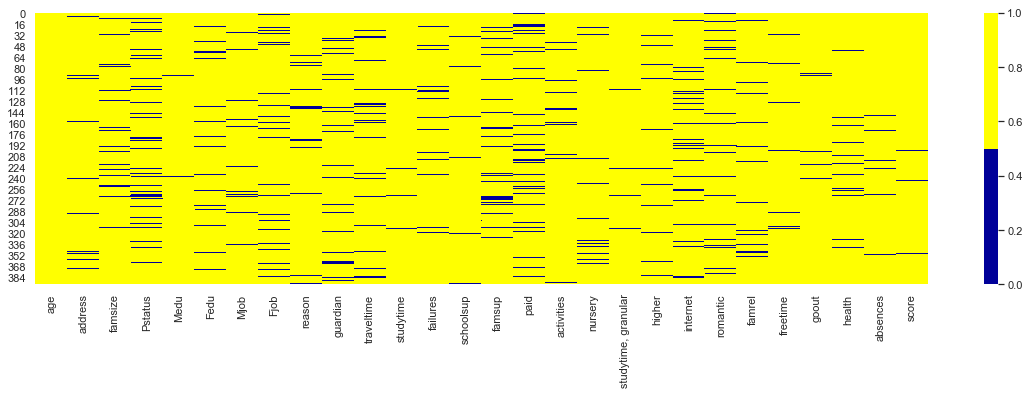

In [481]:
display(stud_math)
stud_math.info()
#Грфическое изображение пропусков данных
sns.set(rc={'figure.figsize':(20, 5)})
cols = stud_math.columns[2:33] # 30 колонок
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(stud_math[cols].notnull(), cmap=sns.color_palette(colours))

Всего 395 строк. Целевой столбец - score  - содержит пропуски, поэтому эти строки можно удалить.
Столбцы school, sex, age - пропусков не содержат.
Остальные столбцы содержат различное количество пропусков, есть смысл написать функцию, 
которая будет подсчитывать количество пропусков для дальнейшего анализа.

In [482]:

#Функция для рассчета стат.величин и выбросов
#Для строковых столбцов
def plot_str(df,col):

    print('Распределение для столбца (не числовой):', col)
    fig,ax=plt.subplots()
    sns.countplot(df.loc[:,col], ax=ax)
    plt.show()
#поиск пустых  Nan значений в символьном  столбце, расчет процента потерянных значений
    n=100-(df[col].count()/df.shape[0]*100)
    print('уникальных значений ', len(df[col].dropna().unique()))
    print ('пустых значений,%', round(n,2))
    stud_math.score.unique()

#Для числовых столбцов
def plot_num (df,col_name, borders=None):
    sns.set(rc={'figure.figsize':(5, 5)})
    print('Распределение для столбца (числовой):', col_name)
    
    fig,ax=plt.subplots()
    df.loc[:,col_name].hist(ax=ax)
    ax.set_xlabel(col_name)
    ax.set_ylabel('кол-во')
    plt.show()
    print (df[col_name].count())
    print (df.shape[0])

    n=100-(df[col_name].count()/df.shape[0]*100)
    print ('пустых значений,%', round(n,2))
    
    if borders is not None:
        print ('выбросы по условию ', borders)
        display(df[(~df.loc[:,col_name].between(borders[0],borders[1]))&pd.notnull(df.loc[:,col_name])])
#функция для рисования "усов"  
def get_boxplot(df,column):
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:30])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для ' + column)
    plt.show()    
#Функция по расчету коэффициента стьюдента из 
def get_stat_dif(df,column):
    cols = df.loc[:, column].value_counts(dropna =True).index[:30]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


### Предобработка данных:

In [483]:
numbers_colmn_list=[]
YN_list=[]

#Переименовать заголовки столбцов
stud_math.columns=['school','sex','age','address','famsize','pstatus','medu','fedu','mjob','fjob','reason','guardian','traveltime',
                   'studytime','failures','schoolsup','famsup','paid','activities','nursery','studytime_granular','higher','internet',
                   'romantic','famrel','freetime','goout','health','absences','score']

#формируем список столбцов с числовыми значениями
numbers_colmn_list=(stud_math.select_dtypes(include=[np.number])).columns.values.tolist()

#удаляем концевые пробелы в строках (не числовые и не NaN значения), заменяем nan 
for val in stud_math.columns:
#    print(val)    
    if val not in numbers_colmn_list:
#            print(val)
            stud_math[val]=stud_math[val].apply(lambda x: x.strip()  if pd.notna(x) else np.nan)

#возврат списка столцов с заданным типом
#список столбцов с да/нет
YN_list = (stud_math.isin(['yes', 'no','Yes','No'])).any().reset_index(drop=False)
YN_list.columns=['col','val']
YN_list = YN_list[YN_list['val']==True]['col'].to_list()

print (numbers_colmn_list,'\n' ,YN_list )

['age', 'medu', 'fedu', 'traveltime', 'studytime', 'failures', 'studytime_granular', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score'] 
 ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [484]:
stud_math

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0



### Целевой столбец (для прогнозирвоания) - score. Проверяем на пропуски и удаляем ненужные строки.

In [485]:
stud_math=stud_math[pd.notnull(stud_math.score)]
stud_math=stud_math.reset_index()

### Смотрим на распределение цифровых столбцов (список был определен в начале numbers_colmn_list)

Распределение для столбца (числовой): score


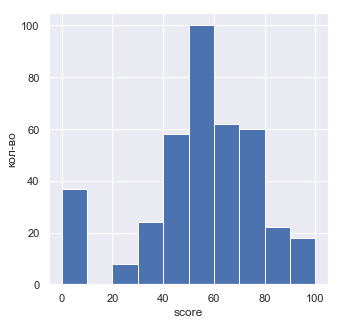

389
389
пустых значений,% 0.0
Распределение для столбца (числовой): age


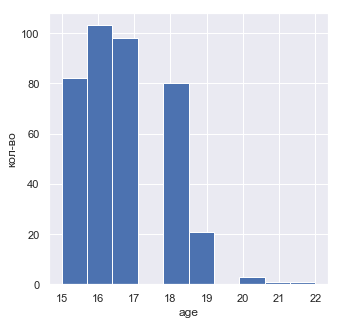

389
389
пустых значений,% 0.0
выбросы по условию  [15, 22]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): medu


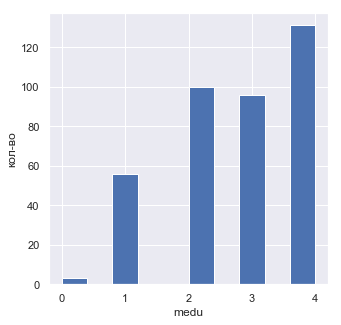

386
389
пустых значений,% 0.77
выбросы по условию  [0, 4]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): fedu


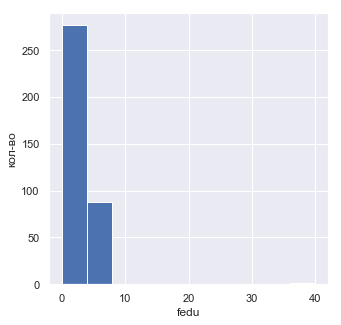

365
389
пустых значений,% 6.17
выбросы по условию  [0, 4]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Распределение для столбца (числовой): traveltime


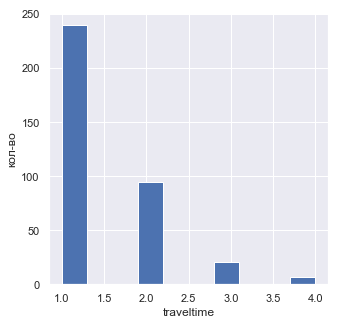

361
389
пустых значений,% 7.2
выбросы по условию  [0, 4]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): studytime


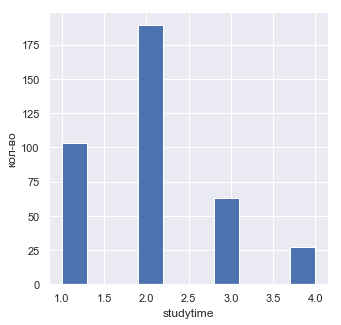

382
389
пустых значений,% 1.8
выбросы по условию  [0, 4]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): failures


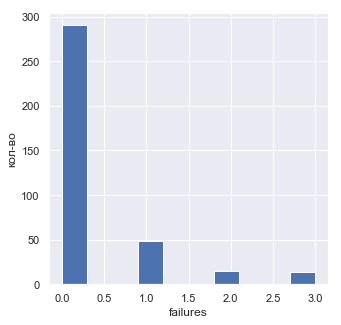

367
389
пустых значений,% 5.66
Распределение для столбца (числовой): studytime_granular


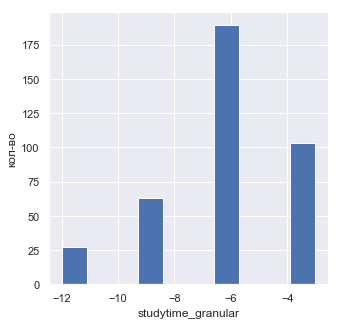

382
389
пустых значений,% 1.8
Распределение для столбца (числовой): famrel


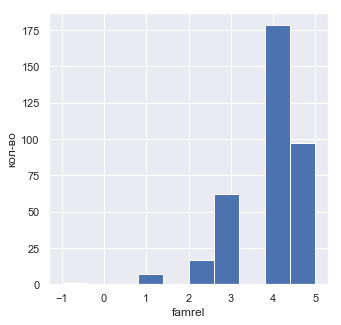

362
389
пустых значений,% 6.94
выбросы по условию  [0, 5]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


Распределение для столбца (числовой): freetime


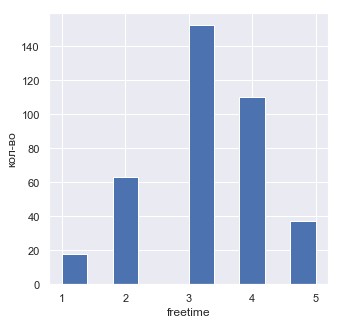

380
389
пустых значений,% 2.31
выбросы по условию  [0, 5]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): goout


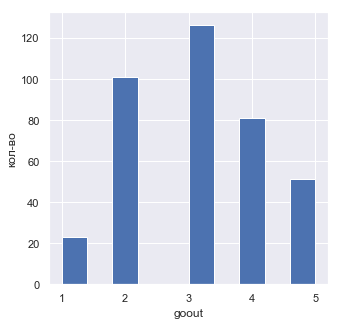

382
389
пустых значений,% 1.8
выбросы по условию  [0, 5]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): health


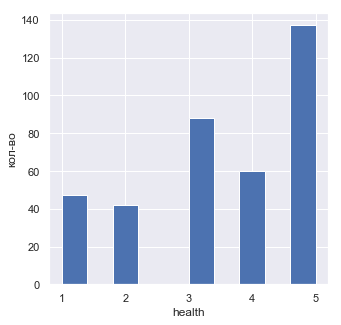

374
389
пустых значений,% 3.86
выбросы по условию  [0, 5]


,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score


Распределение для столбца (числовой): absences


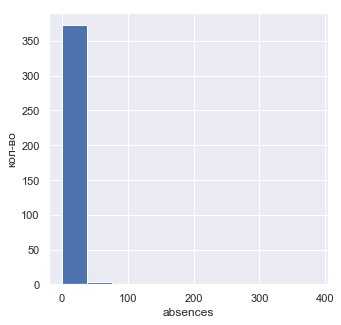

378
389
пустых значений,% 2.83
Распределение для столбца (числовой): score


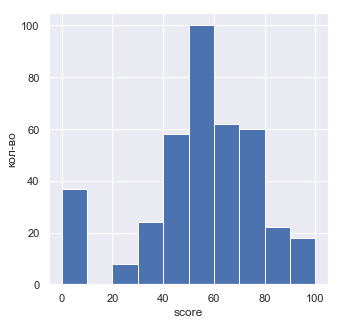

389
389
пустых значений,% 0.0


In [486]:
plot_num(stud_math,'score')
for column in numbers_colmn_list:
    borders=None
    if column=='age': borders=[15,22]
    elif column in ['medu','fedu','traveltime','studytime']: borders=[0,4]
    elif column in ['famrel','freetime','goout','health']: borders=[0,5]    
    plot_num(stud_math,column,borders)

### Выводы по чиловым столбцам
*score* - Похожее на выброс некоторое количество нулевых оценок. В отстутствие информации об алгоритме проставления оценки 0.0 - ни игнорировать, ни удалять эти строки не можем. 
        Требуется уточнение

*age* -   возраст 22  - выброс, но по условию задачи он может быть, поэтому выбросом не является

*medu, fedu* просматривается закономерность - множества как бы зеркалят друг друга, при этом в fedu большой процент пропусков - около 7%. Можно рассмотреть возможность 
        заполнения пропусков. 
        
*traveltime, studytime* - категориальный признак, нет смысла исследовать его как чиcловое распределение, однако он может влиять на целевую переменную

*failures* - Не понятен алгоритм обоснования спосоа определения признака: много неудач - 0, 0 неудач - тоже 0. Требует уточнения 
        и в зависимости от этого включать или не включать в модель. В таком виде столбец не несет информативного смысла.
        
*studytime_granular* - зеркальное отражение графы studytime, вероятно, с высокой корреляцией. Проверить, если корреляция близка к 1, то столбец нужно удалить, т.к. смысл 
        его неизвестен (не описан) и статистической ценности не представляет
        
*famrel, freetime, goout, health*  - можно рассмотреть зависимость оценок от оценки внутрисемейных отношений и количества свободного времени, 
        времени с друзьями, уровня здоровья
        
*absences*  - очевидно, здесь есть выброс, этот признак нужно исследовать после удаления выбросов

В целом пропуски есть, но их не много. 
Есть данные, не подходящие по условию задачи, по-видимому, это опечатки, они будут исправлены.

### Исправление опечаток

In [488]:
stud_math.fedu=stud_math.fedu.apply(lambda x: 4 if x==40 else x)
stud_math.famrel=stud_math.famrel.apply(lambda x: 1 if x==-1 else x)


### Устранение выбросов:

In [489]:
q=stud_math.absences.describe()
stud_math[~stud_math.absences.between(q[4]-1.5*(q[6]-q[4]),q[6]+1.5*(q[6]-q[4]))&pd.notnull(stud_math.loc[:,'absences'])]

,index,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
204,205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
215,216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
221,222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
258,260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
273,276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


Есть два выброса, которые, очевидно, сильно искажают статистику, превышая количество дней в учебном году. Заменим их Nan, поскольку они очевидно ошибочны и снова посмотрим получившееся распределение и проверим выбросы

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
204,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
215,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
258,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
273,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0
274,GP,M,18,U,GT3,T,4.0,4.0,NaN,services,home,mother,2.0,1.0,0.0,no,no,yes,yes,yes,-3.0,yes,yes,no,3.0,2.0,4.0,3.0,22.0,45.0


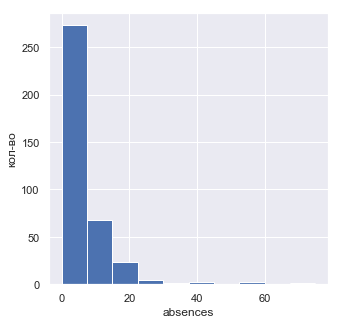

In [490]:
#Удаляем непонятный столбец index
stud_math=stud_math.drop('index',1)
#Заменяем значения >200
stud_math.absences=stud_math.absences.apply(lambda x: np.nan if x>200 else x)
display(stud_math[~stud_math.absences.between(q[4]-1.5*(q[6]-q[4]),q[6]+1.5*(q[6]-q[4]))&pd.notnull(stud_math.loc[:,'absences'])])
fig,ax=plt.subplots()
stud_math.loc[:,'absences'].hist(ax=ax)
ax.set_xlabel('absences')
ax.set_ylabel('кол-во')
plt.show()



Несмотря на оставшиеся выбросы оставляем датасет в таком виде, поскольку здравый смысл говорит о том, что такие данные имеют место быть и могут повлиять на результат.

### Распределение по нечисловым  столбцам

Распределение для столбца (не числовой): school


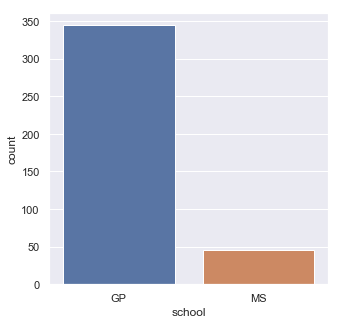

уникальных значений  2
пустых значений,% 0.0
Распределение для столбца (не числовой): sex


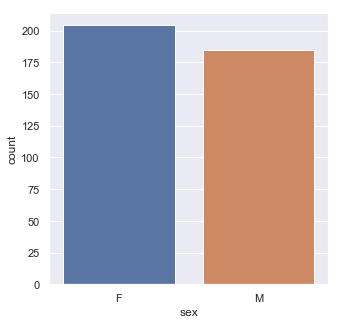

уникальных значений  2
пустых значений,% 0.0
Распределение для столбца (не числовой): address


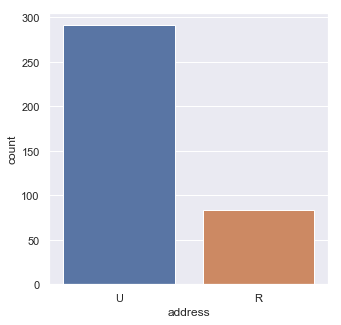

уникальных значений  2
пустых значений,% 3.86
Распределение для столбца (не числовой): famsize


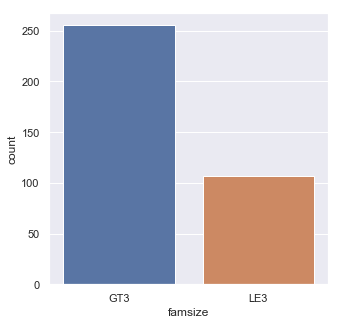

уникальных значений  2
пустых значений,% 6.94
Распределение для столбца (не числовой): pstatus


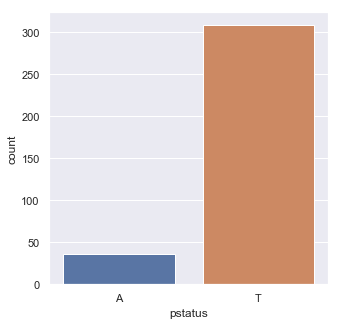

уникальных значений  2
пустых значений,% 11.57
Распределение для столбца (не числовой): mjob


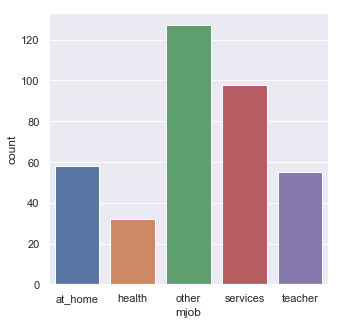

уникальных значений  5
пустых значений,% 4.88
Распределение для столбца (не числовой): fjob


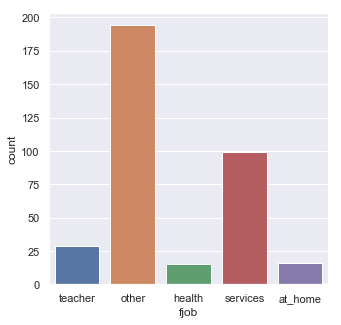

уникальных значений  5
пустых значений,% 9.25
Распределение для столбца (не числовой): reason


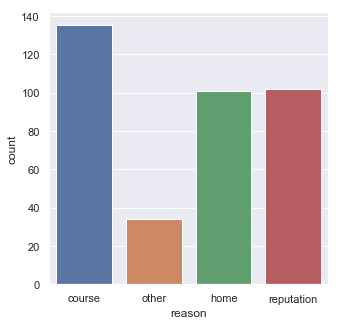

уникальных значений  4
пустых значений,% 4.37
Распределение для столбца (не числовой): guardian


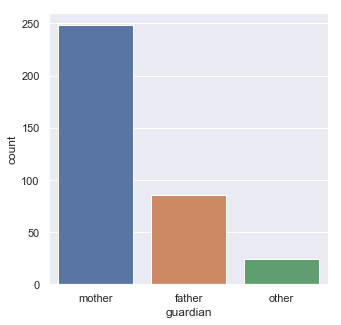

уникальных значений  3
пустых значений,% 7.97
Распределение для столбца (не числовой): schoolsup


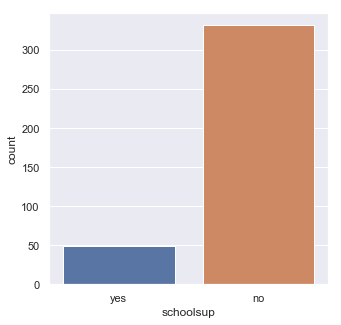

уникальных значений  2
пустых значений,% 2.31
Распределение для столбца (не числовой): famsup


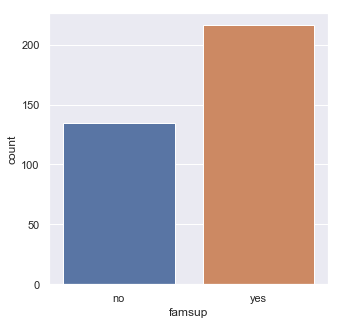

уникальных значений  2
пустых значений,% 9.77
Распределение для столбца (не числовой): paid


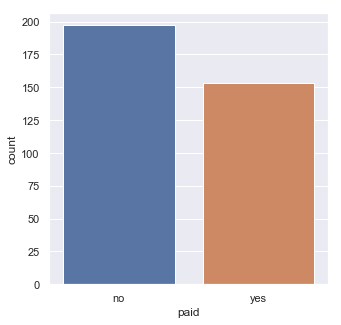

уникальных значений  2
пустых значений,% 10.03
Распределение для столбца (не числовой): activities


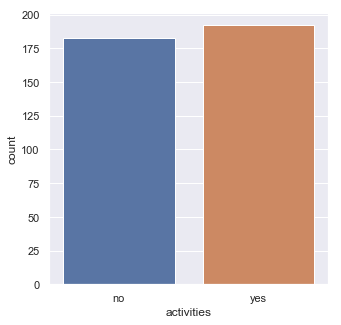

уникальных значений  2
пустых значений,% 3.6
Распределение для столбца (не числовой): nursery


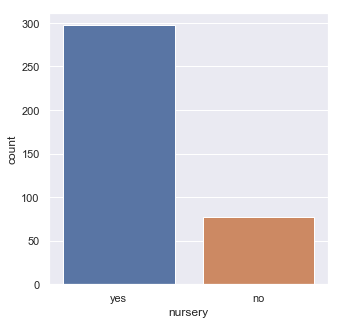

уникальных значений  2
пустых значений,% 3.86
Распределение для столбца (не числовой): higher


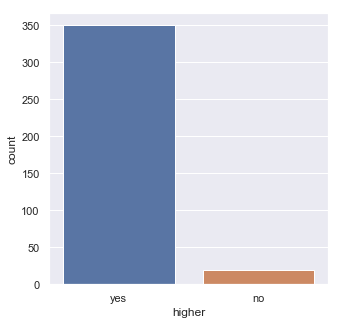

уникальных значений  2
пустых значений,% 5.14
Распределение для столбца (не числовой): internet


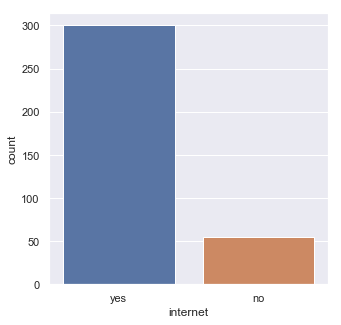

уникальных значений  2
пустых значений,% 8.74
Распределение для столбца (не числовой): romantic


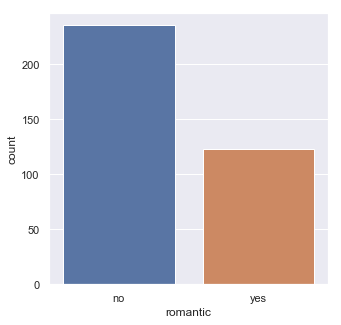

уникальных значений  2
пустых значений,% 7.97


In [491]:
for column in stud_math.columns:
    if column not in numbers_colmn_list and column!='index':    
        plot_str(stud_math,column)

### Выводы по нечсиловым столбцам
*school*  - В обзоре представлены всего две школы, этого может быть маловато для обширного анализа, при том, что количество учащихся распределено неравномерно.

*sex* - Результаты примерно одинаково распределны по полу

*address* - Результаты говорят о том, что большинство участников живут в черте города. Данные распределены неравномрно, но пустых значений менее 5%, можно попытаться 
    использовать в поиске зависимостей

*famsize* - у большинства учеников - участников датасета семья больше 3 человек,  пропусков менее 10%, можно использовать данные

*pstatus* - Подавляющее большинство родителей детей - участников опроса живут совместно, скорее всего этот признак не окажет влияния на результат исследования

*mjob, fjob* - работа матери и отца. На первый взгляд ценности для исследования не представляют, но можно попытаться найти закономерность в занятоости матери и успеваемости, 
    т.е. столбец mjob преобразовать в булево работает/не работает

*reason* - причина выбора школы. Чаще всего причина выбора школы - учебная программа. Т.к. в датасете явное преобладание одной школы, то, возможно, 
    есть взаимосвязь и с успеваемостью. Пропусков не много, можно оставить этот столбец для дальнейшего исследования.

*guardian* - Опекун. Пустых значений не много, по идее их можно заполнить значением other, но смысла это делать пока не вижу.

*schoolsup* - По большей части участники датасете не получают дополнительной учебной поддержки, но от этого признака сильно может зависеть результат оценки, 
    колонку оставляем, пропусков не много.

*famsup* - а вот данные семейной поддержки говорят о том, что поддержка все-таки оказывается. 
Возможно, есть смысл schoolsup и famsup собрать в один признак (образовательная поддержка ученика)

*paid*  - дополнительные занятия имеют примерно половина (чуть меньше) учеников. Требуется уточнение, не является ли этот признак агрегированным признаком schoolsup и famsup.
    если да, то предыдущие два рихнака можно удалить и использовать только этот.

*activities* - дополнительные внеучебные занятие могут оказать влияние на результативность обучения, теоретически, в худшую сторону. Возможно, сделует рассмотерть взаимосвязь.
    Данные распределениы равномерно, пропусков не много.

*nursery* - детский сад. Большинство участников посещало детский сад, пропусков по признаку не много. Столбец можно сотавить для дальнейшего исследования.

*higher* - почти все участники хотят получить высшее образование. Пропусков не много, их можно заполнить значением "Да"

*internet* - наличие интеренет дома вряд ли может быть использовано для прогноза, процент пропусков по столбцу больше, чем в других графах и у большинства дома интернет есть.

*romantic* - признак спорный, пропусков много, и он достаточно нестабильный, учитывая разброс  возраста участников. Не учитываем.

### Строим матрицу корреляции числовых столбцов 
и выводим ее в графическом виде

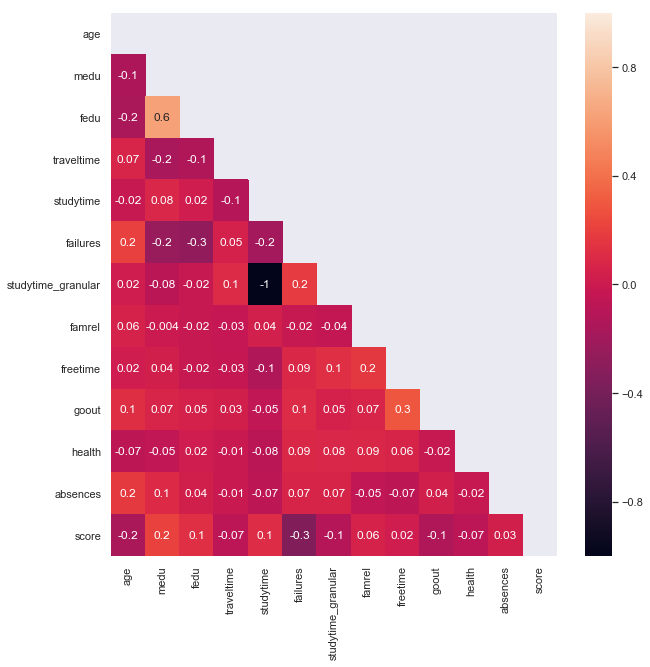

In [492]:
sns.set(rc={'figure.figsize':(10, 10)})
matrix = np.triu(stud_math.corr())
sns.heatmap(stud_math.corr(),annot=True,fmt='.1g',mask=matrix)

Сильная обратная корреляция наблюдается по столбцу studytume  и studytume_granular, поэтому один из них для будущей модели бесполезен. Т.к. studytume_granular не описан в задании и его значение неизвестно, удаляем его. Также видим достаточно высокую корреляцию между образованием матери и образованием отца. т.к. по графе medu пропусков почти нет, а по графе fedu пропусков достаточно много, можем использовать только одну графу для анализа либо заполнить недостающие пропуски в графе fedu значениями из medu.

In [493]:
#Удаляем ненужные столбцы
stud_math=stud_math.drop('studytime_granular',1)
stud_math.fedu=stud_math.fedu.apply(lambda x: stud_math.fedu if pd.isnull(x) else x )

Остальные переменные коррелируют слабо между собой и с целевой колонкой.


### Поиск переменных, не влияющих на целевую переменную


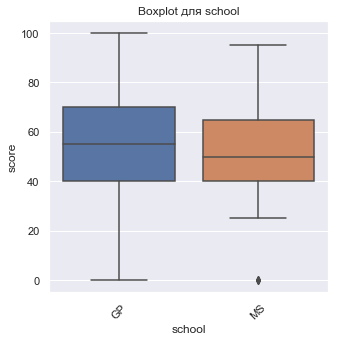

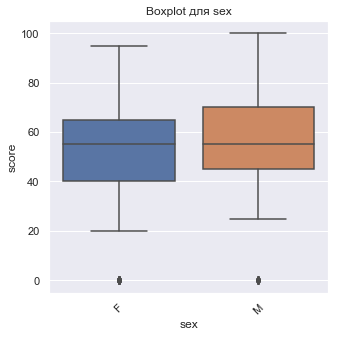

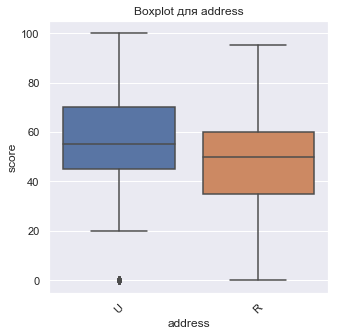

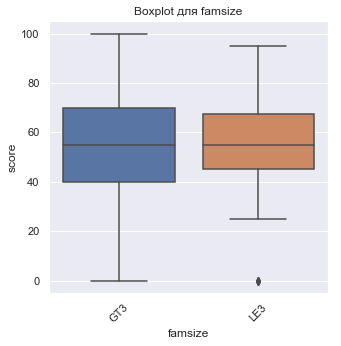

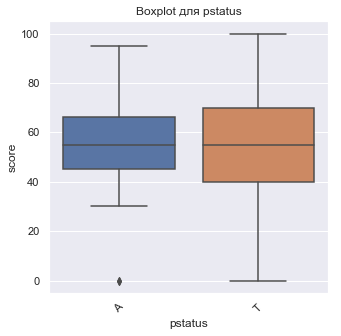

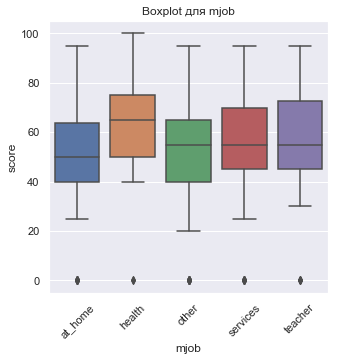

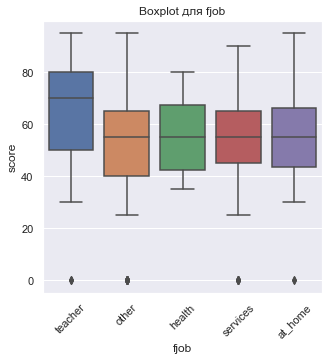

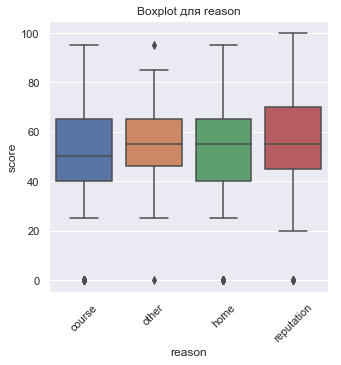

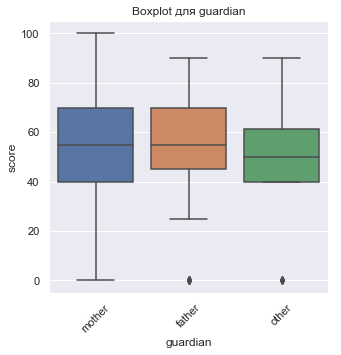

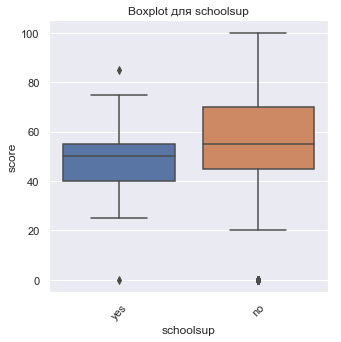

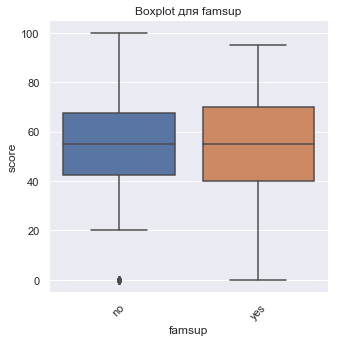

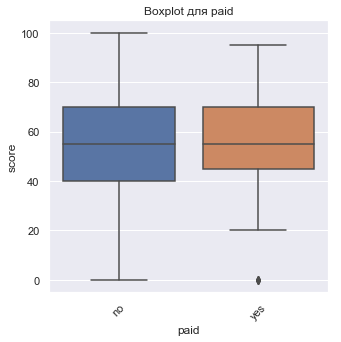

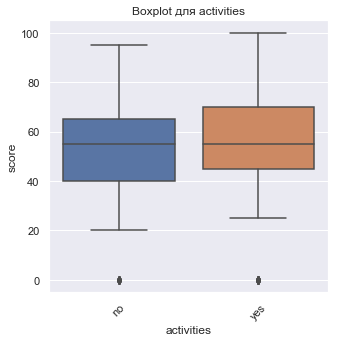

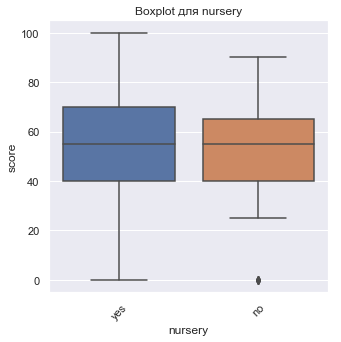

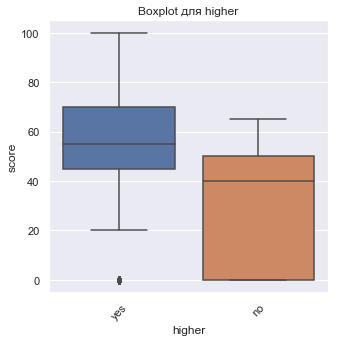

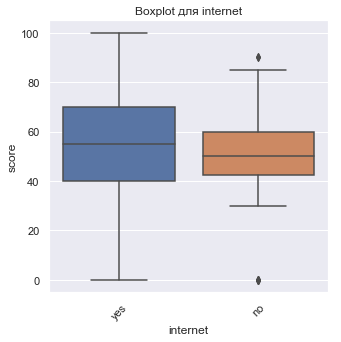

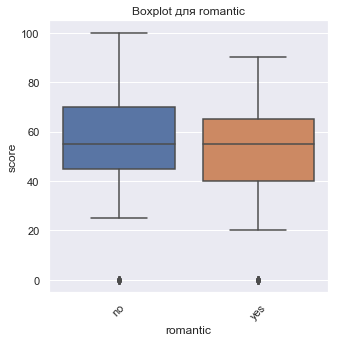

In [494]:
#Строим "Усы" для номинативных переменных
for column in stud_math.columns:
    if column not in numbers_colmn_list and column!='index':    
        get_boxplot(stud_math,column)
    

Видно, что данные о романтических отношениях и посещении детского сада должны минимально влиять на результат экзамена по математике, как и предполагалось выше. 
Также подтверждается предположение, что графы paid и schoosup мало влияют на результат. По переменной activities (было предположение о сильном влиянии на оценку) 
предположение не подтвердилось, следует проверить еще.


In [496]:
#Проверяем тестом Стюдента колонки, требующие внимания:
for column in stud_math.columns:
    if column not in numbers_colmn_list :    
        get_stat_dif(stud_math,column)


Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


# Выводы
Различные методы дали разные результаты. Соответственно использовать лишь один метод при определении совокупности переменных для построения модели нецелесообразно. 
В нашем случае При построении датасета для будующей модели оставляем следующие переменные:

*medu,fedu* - есть положительная более высокая корреляция, чемс другими переменными

*studytime* - время на учебу попложительно коррелирует с оценкой, хоть и невысоко.

*goout* - наблюдается не сильная обратная корреляция с целевым признаком, но она есть.

failures не включаем до уточнения алгоритма и логики простановки признака.

*Mjob* - Как и предполагалось изначально, занятость мамы достаточно сильно влияет на успеваемость

*address* - по обоим показателям признак влияет на итоговую оценку

*higer* - Важный принак: стремление получить высшее образование влияет на результаты теста

*romantic*

Данные содержат незначительное количество пропусков, поэтому заполнять их не нужно. По графе fedu пустые значения заполненны из графы medu, как сильно коррелирующие.
Также для дальнейшей работы построения модели следует уточнить, как проставлялась оценка 0: реальна ли эта оценка, либо это показатель ниже какого-то уровня: в зависимости от этого принимать решение о включении или невключении переменной в модель.

In [497]:
model=stud_math[['score','medu','fedu','studytime','mjob','address','higher','romantic','goout']]
model

,score,medu,fedu,studytime,mjob,address,higher,romantic,goout
0,30.0,4.0,4.0,2.0,at_home,U,yes,no,4.0
1,30.0,1.0,1.0,2.0,at_home,U,yes,no,3.0
2,50.0,1.0,1.0,2.0,at_home,U,yes,NaN,2.0
3,75.0,4.0,2.0,3.0,health,U,yes,yes,2.0
4,50.0,3.0,3.0,2.0,other,U,yes,no,2.0
...,...,...,...,...,...,...,...,...,...
384,45.0,2.0,2.0,2.0,services,U,yes,no,4.0
385,80.0,3.0,1.0,1.0,services,U,yes,no,5.0
386,35.0,1.0,1.0,1.0,other,R,NaN,no,3.0
387,50.0,3.0,2.0,1.0,services,R,yes,no,1.0
